In [ ]:
!pip install scipy==1.9.3 --force-reinstall

In [2]:
# import scipy
# def derivative(func, x0, dx=1e-6, n=1, order=3):
#     if n != 1 or order != 3:
#         raise NotImplementedError("Only n=1 and order=3 supported")
#     return (func(x0 + dx) - func(x0 - dx)) / (2 * dx)

# scipy.misc.derivative = derivative

import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from ADRpy import atmospheres as at
from importlib import reload
import helper_functions
helper_functions = reload(helper_functions)
from helper_functions import *
import specs
specs = reload(specs)
from specs import *
import airfoil_functions
airfoil_functions = reload(airfoil_functions)
from airfoil_functions import *
from airfoils import Airfoil

In [3]:
foil = Airfoil.NACA4('2412')
x,y = foil.all_points

foil_vt = Airfoil.NACA4('0012')
x_vt,y_vt = foil_vt.all_points

In [4]:
# Reynolds_numbers = [calculate_reynolds_number(80, 1, 0), calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = list(range(-15,30,1))  # degrees
# phases = ["takeoff", "cruise"]  # one per Re
# Reynolds_numbers = [calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = [29]  # degrees
# phases = ["cruise"]  # one per Re

# get_airfoil_params_with_flap_effect_naca(
#     airfoil_name="2412",
#     Reynolds_numbers=Reynolds_numbers,
#     deflection_angles=deflection_angles,
#     phases=phases
# )

In [4]:
deflections_dict = {}
deflection_angles = list(range(-15,31,1))  # degrees
phases = ["takeoff", "cruise"]  # one per Re
for def_angle in deflection_angles:
    for phase in phases:

        deflections_dict[f"{phase}_{def_angle}"] = load_xfoil_polar(f'ht_deflections/NACA2412_def ({def_angle} deg)_{phase}.plr')


In [5]:
# airfoil_coeffs_vs_alpha = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(200, 1, 3000))}.dat')
# airfoil_coeffs_vs_alpha_to = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(80, 1, 0))}.dat')
airfoil_coeffs_vs_alpha_vt = load_xfoil_polar(f'NACA 0012-{int(calculate_reynolds_number(200, 1, 3000))}.dat')



In [5]:

# cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseout_cg_from_nose_m"], 
#                                                 current_values["cruiseout_cl"], current_values["tail_arm_m"], eta_h, cruiseout_delt_cl_from_thrust, current_values["cruiseout_angle_of_attack_deg"], "cruiseout")



# def cruise_trim_analysis(
#     neutral_point_m,
#     cg_from_nose,
#     cl_cruise,
#     tail_arm_m,
#     eta_h,
#     delta_cl_from_thrust,
#     current_angle_of_attack,
#     phase
# ):

def cruise_trim_analysis(current_values, assumed_and_set, hard_constraints, phase):
    
    
    rho = get_air_density(hard_constraints["cruise_altitude_m"])
    v_ms = kmh_to_ms(current_values[f"{phase}_speed_kmh"])
    q = 0.5 * rho * v_ms**2
    
    phase_for_delta = ""
    if ("cruise" in phase) or (phase == "loiter"):
        phase_for_delta = "cruise"
    elif phase in ["takeoff", "landing"]:
        phase_for_delta = "takeoff"

    dict_of_aero_coeffs_vs_deflections_at_alpha = {}
    effective_angle_of_attack = current_values[f"{phase}_angle_of_attack_deg"] * (1-assumed_and_set['ht_downwash_efficiency_coeff']) + assumed_and_set["ht_incident_angle"]
    for deg in range(-15,31,1):
        try:
            dict_of_aero_coeffs_vs_deflections_at_alpha[str(deg)] = get_coefficients_at_alpha(deflections_dict[f"{phase_for_delta}_{deg}"], effective_angle_of_attack)
        except Exception as e:
            print(deg, "---", e)

    delta_vs_alpha_frame = pd.DataFrame(dict_of_aero_coeffs_vs_deflections_at_alpha).T
    delta_vs_alpha_frame["alpha"] = delta_vs_alpha_frame.index.astype(int)
    
    delta_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, phase)
    
    # print("thrust: ",delta_cl_from_thrust)
    wing_cl_to_counter = ((current_values[f"{phase}_cg_from_nose_m"] - current_values["neutral_point_m"]) * (current_values["wing_area_m2"]/current_values["horizontal_tail_area_m2"]) * current_values[f"{phase}_cl"] / current_values["tail_arm_m"])
    
    # print("wing: ", wing_cl_to_counter)
    required_cl_tail = wing_cl_to_counter + delta_cl_from_thrust

    
    ht_deflection_angle = get_row_for_cl(delta_vs_alpha_frame, required_cl_tail)["alpha"]
    
    
    return {
        "cl_tail_required": required_cl_tail,
        "delta_elevator_deg": ht_deflection_angle,
    }



In [626]:
ABS_TOL = {
    "cruiseout_static_margin":   1/10,
    "loiter_static_margin":      1/10,
    "cruiseback_static_margin":  1/10,   # << key fix
    "cruiseout_cl":              1/100,
    "loiter_cl":                 1/100,
    "cruiseback_cl":             1/100,
    # add more if needed
}

list(ABS_TOL.keys())

['cruiseout_static_margin',
 'loiter_static_margin',
 'cruiseback_static_margin',
 'cruiseout_cl',
 'loiter_cl',
 'cruiseback_cl']

In [6]:
def relax(old, new, lam=0.25):
    return (1.0 - lam)*old + lam*new



def key_error(curr, prev, key, target_error, eps=1e-9):

    
    ABS_TOL = {
        "cruiseout_static_margin":   target_error/10,
        "loiter_static_margin":      target_error/10,
        "cruiseback_static_margin":  target_error/10,   # << key fix
        "cruiseout_cl":              target_error/100,
        "loiter_cl":                 target_error/100,
        "cruiseback_cl":             target_error/100,
        # add more if needed
    }
    REL_TOL = target_error  # 2% for most quantities

    # hybrid: absolute OR relative

    
    abs_err = abs(curr - prev)
    rel_den = max(abs(prev), eps)#, 1.0 if key.endswith("_static_margin") else eps)
    rel_err = abs_err / rel_den
    # accept if either test passes
    # if key in ABS_TOL:
    #     return abs_err
    # else:
    return rel_err
    
def aitken(x0,x1,x2):

    if (x1 - x0)*(x2 - x1) >= 0:
        return relax(x1, x2, 0.5)
    
    num = (x2-x1)**2
    den = x2- 2*x1 + x0

    x_aitken = x2 - num/(den if den != 0 else 1e-9)
        
    return x_aitken

def aitken_safe(x0, x1, x2, eps=1e-12, max_step_frac=0.20):
    den = x2 - 2.0*x1 + x0
    # Only accelerate if we see alternation (two-cycle signature)
    if (x1 - x0)*(x2 - x1) >= 0.0 or abs(den) < eps:
        return x2
    x_acc = x2 - (x2 - x1)**2 / den
    # clamp the extrapolated jump
    cap = max_step_frac * max(abs(x2), 1e-9)
    dx  = max(-cap, min(cap, x_acc - x2))
    return x2 + dx
    

In [7]:
def refine_design_from_iterable_constraints(
    hard_constraints, assumed_and_set, weights_dict_kg_no_fuel,
    iterable_constraints, deflections_dict,
    target_error=0.02, max_iterations=10
):
    g = 9.81
    cur  = iterable_constraints.copy()
    prev = iterable_constraints.copy()
    aitken_values = iterable_constraints.copy()

    for i in range(max_iterations):
        # ------------------------------
        # 0) Atmosphere & phase speeds
        # ------------------------------
        rho   = get_air_density(hard_constraints["cruise_altitude_m"])
        Vc_ms = kmh_to_ms(cur["cruiseout_speed_kmh"])
        Vl_ms = kmh_to_ms(cur["loiter_speed_kmh"])
        Vb_ms = kmh_to_ms(cur["cruiseback_speed_kmh"])

        # ---------------------------------------------------------
        # 1) GEOMETRY (wing/tail/fuselage) — fuselage sizing FIRST
        # ---------------------------------------------------------
        # Wing geometry (use the current wing area; will be refreshed at end of iter)
        
        cur["wing_span_m"] = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]     = cur["wing_area_m2"] / cur["wing_span_m"]

        # Geometric tail arm (fixed AC→AC; do NOT tie to moving wing AC)
        cur["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * cur["chord_m"]
        

        # Fuselage main length from your sizing model (do this BEFORE masses & CGs)
        cur["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, cur, False)
        # 
        

        # Wing LE station as a fraction of fuselage length (geometry placement)
        cur["wing_le_position_m"] = assumed_and_set["wing_le_position_fuselage_length_coeff"] * cur["fuselage_body_length_m"]

        # cur["tail_arm_m"] = cur["fuselage_body_length_m"] * 0.9 - (cur['wing_le_position_m'] + 0.25*cur["chord_m"])

        # Tail areas from volume coefficients (use current tail arm)
        cur["horizontal_tail_area_m2"] = (
            assumed_and_set["horizontal_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["chord_m"]) / cur["tail_arm_m"]
        )
        cur["vertical_tail_area_m2"] = (
            assumed_and_set["vertical_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["wing_span_m"]) / cur["tail_arm_m"]
        )

        # Tail planform geometry from areas + AR
        cur["h_tail_span_m"], cur["h_tail_chord_m"] = tail_geometry(cur["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
        cur["v_tail_span_m"], cur["v_tail_chord_m"] = tail_geometry(cur["vertical_tail_area_m2"],   assumed_and_set["AR_vertical"])

        cur["x_ht_le_m"] = cur["wing_le_position_m"] + 0.25*cur["chord_m"] + cur["tail_arm_m"] - 0.25*cur["h_tail_chord_m"]
        # -----------------------------------------
        # 2) STRUCTURAL MASSES (per-item components)
        # -----------------------------------------
        # Fuselage mass (depends on sized fuselage geometry)
        fuselage_mass = get_fuselage_mass(
            cur["fuselage_body_length_m"],
            cur["fuselage_body_width_m"],
            cur["fuselage_body_height_m"],
            assumed_and_set
        ) * assumed_and_set["fuselage_internal_supports_mass_multiplier"]
        weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

        # Wing mass via perimeter*span method
        # wing_perimeter = airfoil_perimeter_length(x, y, cur["chord_m"])
        # wing_mass = get_wing_or_tail_mass(
        #     cur["wing_span_m"], wing_perimeter, "wing", assumed_and_set
        # ) * assumed_and_set["wing_internal_supports_mass_multiplier"]
        
        wing_mass = get_wing_or_tail_mass(
            cur["wing_area_m2"], assumed_and_set, "wing"
        ) * assumed_and_set["wing_internal_supports_mass_multiplier"]

        weights_dict_kg_no_fuel["wing"] = wing_mass

        # Horizontal tail mass
        # htail_perimeter = airfoil_perimeter_length(x, y, cur["h_tail_chord_m"])
        # htail_mass = get_wing_or_tail_mass(
        #     cur["h_tail_span_m"], htail_perimeter, "tail", assumed_and_set
        # ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        htail_mass = get_wing_or_tail_mass(
            cur["horizontal_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        # Vertical tail mass
        # vtail_perimeter = airfoil_perimeter_length(x_vt, y_vt, cur["v_tail_chord_m"])
        # vtail_mass = get_wing_or_tail_mass(
        #     cur["v_tail_span_m"], vtail_perimeter, "tail", assumed_and_set
        # ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        vtail_mass = get_wing_or_tail_mass(
            cur["vertical_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        weights_dict_kg_no_fuel["horizontal_tail"] = htail_mass
        weights_dict_kg_no_fuel["vertical_tail"]   = vtail_mass
        weights_dict_kg_no_fuel["tails"]           = htail_mass + vtail_mass  # if you still use a combined key

        # ------------------------------------------------
        # 3) FUEL CAPACITY & DISTRIBUTION (by geometry)
        # ------------------------------------------------
        # Fuselage tank capacity from sized cross-section and your tank length
        fus_cs_area = (
            (cur["fuselage_body_width_m"]  - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *
            (cur["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
        )
        fus_tank_vol_m3 = assumed_and_set["fuselage_fuel_tank_length"] * fus_cs_area
        fus_tank_cap_kg = fus_tank_vol_m3 * 1000.0 * assumed_and_set["fuel_density_kgL"]

        # Wing tank capacity from your helper (uses current wing geometry)
        wing_tank_vol_m3 = wing_fuel_tank_volume("naca2412_coords.dat", cur, 0.25, 0.65)

        # Fuel from previous iteration (or initial seed)
        fuel_total = cur.get("fuel_kg", 0.0)

        # Split: fill fuselage first, rest to wing
        fus_fuel_kg  = min(fuel_total, fus_tank_cap_kg)
        wing_fuel_kg = max(0.0, fuel_total - fus_fuel_kg)

        # ------------------------------------------
        # 4) COMPONENT POSITIONS (for CG calculation)
        # ------------------------------------------
        comp_x, comp_z = estimate_component_positions(cur, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

        # ==========================================
        # 5) PHASES (CG → NP → TRIM → DRAG/POWER)
        # ==========================================

        # ---------- CRUISE OUT ----------
        wts_c = weights_dict_kg_no_fuel.copy()
        wts_c["fuselage_fuel"] = fus_fuel_kg
        wts_c["wing_fuel"]     = wing_fuel_kg
        cur["cruiseout_mass_kg"] = sum(wts_c.values())

        cur["cruiseout_cg_from_nose_m"]  = calculate_cg(wts_c, comp_x)
        cur["cruiseout_cg_from_floor_m"] = calculate_cg(wts_c, comp_z)

        stab_c = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseout")
        cur["neutral_point_m"]         = stab_c["neutral_point_m"]
        cur["cruiseout_static_margin"] = stab_c["static_margin"]

        trim_c = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseout")
        cur["cruiseout_cl"]                 = trim_c["cl_wing"]
        cur["cruiseout_angle_of_attack_deg"]= trim_c["alpha_wing_deg"]
        cur["cruiseout_cl_tail_required"]   = trim_c["cl_tail_required"]
        cur["cruiseout_delta_elevator_deg"] = trim_c["delta_elevator_deg"]

        Cd0_sec = get_row_for_cl(deflections_dict["cruise_0"], 0)["CD"]  # section CD at CL≈0 for parasite baseline
        cur["cruiseout_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseout_cl_tail_required"], assumed_and_set["AR_horizontal"])
        cur["cruiseout_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseout_cl"],              assumed_and_set["aspect_ratio"])

        D_c = 0.5*rho*Vc_ms**2 * (cur["wing_area_m2"]*cur["cruiseout_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseout_cd_tail"])
        P_c = D_c * Vc_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseout_power_kw"] = P_c

        sfc_c = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_c)
        cur["cruiseout_sfc"] = sfc_c["sfc_cruise"]
        cur["cruiseout_rpm"] = sfc_c["rpm_cruise"]
        cur["cruiseout_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseout_speed_kmh"]
        fuel_c = P_c * cur["cruiseout_time"] * cur["cruiseout_sfc"]

        # ---------- LOITER ----------
        fus_fuel_l  = max(0.0, fus_fuel_kg - fuel_c)  # burn from fuselage first per your scheme
        wing_fuel_l = wing_fuel_kg

        wts_l = weights_dict_kg_no_fuel.copy()
        wts_l["fuselage_fuel"] = fus_fuel_l
        wts_l["wing_fuel"]     = wing_fuel_l
        cur["loiter_mass_kg"] = sum(wts_l.values())

        cur["loiter_cg_from_nose_m"]  = calculate_cg(wts_l, comp_x)
        cur["loiter_cg_from_floor_m"] = calculate_cg(wts_l, comp_z)

        stab_l = stability_analysis(cur, assumed_and_set, deflections_dict, "loiter")
        cur["loiter_static_margin"] = stab_l["static_margin"]

        trim_l = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "loiter")
        cur["loiter_cl"]                 = trim_l["cl_wing"]
        cur["loiter_angle_of_attack_deg"]= trim_l["alpha_wing_deg"]
        cur["loiter_cl_tail_required"]   = trim_l["cl_tail_required"]
        cur["loiter_delta_elevator_deg"] = trim_l["delta_elevator_deg"]
        
        cur["loiter_cd_tail"] = calc_cd_total(Cd0_sec, cur["loiter_cl_tail_required"], assumed_and_set["AR_horizontal"])
        cur["loiter_cd"]      = calc_cd_total(Cd0_sec, cur["loiter_cl"],              assumed_and_set["aspect_ratio"])

        D_l = 0.5*rho*Vl_ms**2 * (cur["wing_area_m2"]*cur["loiter_cd"] + cur["horizontal_tail_area_m2"]*cur["loiter_cd_tail"])
        P_l = D_l * Vl_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["loiter_power_kw"] = P_l

        sfc_l = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_l)
        cur["loiter_sfc"] = sfc_l["sfc_cruise"]
        cur["loiter_rpm"] = sfc_l["rpm_cruise"]
        fuel_l = P_l * hard_constraints["loiter_time"] * 1.1 * cur["loiter_sfc"]  # keep your 1.1 margin if desired

        # ---------- CRUISE BACK ----------
        fus_fuel_b  = max(0.0, fus_fuel_l - fuel_l)
        wing_fuel_b = wing_fuel_l  # adjust policy if you also burn wing fuel here

        wts_b = weights_dict_kg_no_fuel.copy()
        wts_b["fuselage_fuel"]  = fus_fuel_b
        wts_b["wing_fuel"]      = wing_fuel_b
        wts_b["internal_payload"] = 0
        wts_b["wing_payload"]     = 0
        cur['cruiseback_mass_kg'] = sum(wts_b.values())

        cur["cruiseback_cg_from_nose_m"]  = calculate_cg(wts_b, comp_x)
        cur["cruiseback_cg_from_floor_m"] = calculate_cg(wts_b, comp_z)

        stab_b = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseback")
        cur["cruiseback_static_margin"] = stab_b["static_margin"]

        # print(cur["cruiseback_static_margin"])

        trim_b = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseback")
        cur["cruiseback_cl"]                 = trim_b["cl_wing"]
        cur["cruiseback_angle_of_attack_deg"]= trim_b["alpha_wing_deg"]
        cur["cruiseback_cl_tail_required"]   = trim_b["cl_tail_required"]
        cur["cruiseback_delta_elevator_deg"] = trim_b["delta_elevator_deg"]

        cur["cruiseback_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseback_cl_tail_required"], assumed_and_set["AR_horizontal"])
        cur["cruiseback_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseback_cl"],              assumed_and_set["aspect_ratio"])

        D_b = 0.5*rho*Vb_ms**2 * (cur["wing_area_m2"]*cur["cruiseback_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseback_cd_tail"])
        P_b = D_b * Vb_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseback_power_kw"] = P_b

        sfc_b = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_b)
        cur["cruiseback_sfc"] = sfc_b["sfc_cruise"]
        cur["cruiseback_rpm"] = sfc_b["rpm_cruise"]
        cur["cruiseback_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseback_speed_kmh"]
        fuel_b = P_b * cur["cruiseback_time"] * cur["cruiseback_sfc"]

        # ---------------------------------------------
        # 6) TOTAL FUEL / MTOW and CAPACITY CHECKS
        # ---------------------------------------------
        cur["fuel_kg"] = fuel_c + fuel_l + fuel_b
        cur["mtow"]    = sum(wts_c.values())
        # print(wts_c)
        # Volume check after refreshed fuel
        cur["required_fuel_volume_m3"]    = cur["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000.0
        cur["space_available_for_fuel_m3"]= fus_tank_vol_m3 + wing_tank_vol_m3

        # ---------------------------------------------
        # 7) OPTIONAL: REFRESH WING AREA (design var)
        # ---------------------------------------------

        # Sw_candidates = [
        #     required_wing_area_consistent(cur, assumed_and_set, hard_constraints, weights_dict_kg_no_fuel, "takeoff"),
        #     required_wing_area_consistent(cur, assumed_and_set, hard_constraints, weights_dict_kg_no_fuel, "cruiseout"),
        #     required_wing_area_consistent(cur, assumed_and_set, hard_constraints, weights_dict_kg_no_fuel, "loiter"),
        #     required_wing_area_consistent(cur, assumed_and_set, hard_constraints, weights_dict_kg_no_fuel, "cruiseback"),
        # ]
        # Sw_target = max(Sw_candidates) * 1.03  # +3% margin
        # cur["wing_area_m2"] = 0.8*cur["wing_area_m2"] + 0.2*Sw_target  # under-relax
        # cur["wing_span_m"]  = (cur["wing_area_m2"]*assumed_and_set["aspect_ratio"])**0.5
        # cur["chord_m"]      = cur["wing_area_m2"]/cur["wing_span_m"]

        cur["wing_area_m2"]   = calc_required_wing_area(cur["mtow"], hard_constraints["CL_max"], rho, hard_constraints["stall_speed_kmh"])
        cur["wing_span_m"]    = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]        = cur["wing_area_m2"] / cur["wing_span_m"]
        cur["wing_loading_pa"]= cur["mtow"] * g / cur["wing_area_m2"]
        cur['high_wing_offset_m'] = (cur['fuselage_body_height_m']/2) - cur["chord_m"]*assumed_and_set['wing_airfoil_thickness_ratio']

        # print(cur['cruiseout_cl'], cur["cruiseout_cl_tail_required"])
        # print(f'wing area: {cur["wing_area_m2"]}')
        # ---------------------------------------------
        # 8) CONVERGENCE (focus on critical scalars)
        # ---------------------------------------------

        for key in cur:
            
            # cur[key] = relax(prev[key], cur[key], lam=1.1)
            

            # if key_rel_error > target_error:
            cur[key] = aitken(aitken_values[key], prev[key], cur[key])
            
           
        rel_err = {k: key_error(cur[k], prev[k], k, target_error) for k in cur}
        
        aitken_values.update(prev)
        prev.update(cur)

        # print(trim_b)

        if all(err < target_error for err in rel_err.values()):
            if cur["required_fuel_volume_m3"] > cur["space_available_for_fuel_m3"]:
                print(f"❌ Fuel volume short: need {cur['required_fuel_volume_m3']:.5f} m³, have {cur['space_available_for_fuel_m3']:.5f} m³.")
            else:
                print(f"Converged in {i+1} iterations.")

             
            return cur

    worst_key = max(rel_err, key=rel_err.get)
    worst_val = rel_err[worst_key]
    print(f"Completed iterations without convergence. Max error: {worst_val} in {worst_key}")    

    return cur


In [810]:
def _refine_design_from_iterable_constraints(hard_constraints, assumed_and_set, weights_dict_kg_no_fuel, iterable_constraints, deflections_dict, target_error=0.02, max_iterations=10):
    # populate constants and constraints

    # try:
        current_values = iterable_constraints.copy()

        
        prev_values = iterable_constraints.copy()
        

        
        for i in range(max_iterations):

            # print(current_values["cruiseout_cl"])
            ## cruise iterations

            # print(f"[Iter {i+1}] " + " | ".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in current_values.items()]))
            
            # h_tail_te_position = current_values["tail_arm_m"] + current_values["cruiseout_cg_from_nose_m"] + 0.75*current_values["h_tail_chord_m"]
            # print(current_values["fuselage_body_length_m"], h_tail_te_position)
            
            cruiseout_v_ms = kmh_to_ms(current_values["cruiseout_speed_kmh"])
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], current_values["cruiseout_cl"], rho, cruiseout_v_ms)
            
            ## cruise out calculations
            # Aerodynamics 

            # cruiseout_cl_dict = closed_form_trim_analysis(current_values, assumed_and_set, hard_constraints, "cruiseout")
            # current_values["cruiseout_cl"] = cruiseout_cl_dict["cl_wing"]
            # current_values["cruiseout_angle_of_attack_deg"] = cruiseout_cl_dict["alpha_wing_deg"]
            # current_values["cruiseout_cl_tail_required"] = cruiseout_cl_dict["cl_tail_required"]
            # current_values["cruiseout_delta_elevator_deg"] = cruiseout_cl_dict["delta_elevator_deg"]

            print(current_values["mtow"])
            cruiseout_mtow = current_values["mtow"]
            cruiseout_tail_lift = -current_values["cruiseout_cl_tail_required"] * (0.5*rho*(kmh_to_ms(current_values["cruiseout_speed_kmh"])**2)*current_values["horizontal_tail_area_m2"])
            cruiseout_extra_kgs = cruiseout_tail_lift / g
            current_values["cruiseout_cd_tail"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["cruiseout_cl_tail_required"], assumed_and_set["AR_horizontal"])
            current_values["cruiseout_cl"] = calc_cl_cruise(cruiseout_mtow+cruiseout_extra_kgs, current_values["cruiseout_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseout_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["cruiseout_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["cruiseout_cd"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["cruiseout_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseout_lift_to_drag"] = current_values["cruiseout_cl"] / (current_values["cruiseout_cd"] + current_values["cruiseout_cd_tail"])
            cruiseout_drag_n = 0.5 * rho * cruiseout_v_ms**2 * (current_values["wing_area_m2"] * current_values["cruiseout_cd"] + current_values["horizontal_tail_area_m2"] * current_values["cruiseout_cd_tail"])
            cruiseout_power_kw = cruiseout_drag_n * cruiseout_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseout_power_kw"] = cruiseout_power_kw

            # Engine interpolation
            cruiseout_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseout_power_kw)
            current_values["cruiseout_sfc"] = cruiseout_sfc_data["sfc_cruise"]
            current_values["cruiseout_rpm"] = cruiseout_sfc_data["rpm_cruise"]
            current_values["cruiseout_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseout_speed_kmh"] # in hours

            cruiseout_fuel_requirement = cruiseout_power_kw * current_values["cruiseout_time"] * current_values["cruiseout_sfc"] 

            ## loiter calculations
            # Aerodynamics 


            loiter_v_ms = kmh_to_ms(current_values["loiter_speed_kmh"])

            # loiter_cl_dict = closed_form_trim_analysis(current_values, assumed_and_set, hard_constraints, "loiter")
            # current_values["loiter_cl"] = loiter_cl_dict["cl_wing"]
            # current_values["loiter_angle_of_attack_deg"] = loiter_cl_dict["alpha_wing_deg"]
            # current_values["loiter_cl_tail_required"] = loiter_cl_dict["cl_tail_required"]
            # current_values["loiter_delta_elevator_deg"] = loiter_cl_dict["delta_elevator_deg"]


            loiter_mtow = current_values["mtow"] - cruiseout_fuel_requirement
            loiter_tail_lift = -current_values["loiter_cl_tail_required"] * (0.5*rho*(kmh_to_ms(current_values["loiter_speed_kmh"])**2)*current_values["horizontal_tail_area_m2"])
            loiter_extra_kgs = loiter_tail_lift / g
            current_values["loiter_cl"] = calc_cl_cruise(loiter_mtow+loiter_extra_kgs, current_values["loiter_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["loiter_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["loiter_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["loiter_cd_tail"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["loiter_cl_tail_required"], assumed_and_set["AR_horizontal"])
            current_values["loiter_cd"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["loiter_cl"], assumed_and_set["aspect_ratio"])
            current_values["loiter_lift_to_drag"] = current_values["loiter_cl"] / (current_values["loiter_cd"] + current_values["loiter_cd_tail"])
            loiter_drag_n = 0.5 * rho * cruiseout_v_ms**2 * (current_values["wing_area_m2"] * current_values["loiter_cd"] + current_values["horizontal_tail_area_m2"] * current_values["loiter_cd_tail"])
            loiter_power_kw = loiter_drag_n * loiter_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["loiter_power_kw"] = loiter_power_kw

            # Engine interpolation
            loiter_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, loiter_power_kw)
            current_values["loiter_sfc"] = loiter_sfc_data["sfc_cruise"]
            current_values["loiter_rpm"] = loiter_sfc_data["rpm_cruise"]

            loiter_fuel_requirement = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["loiter_sfc"] 

            estimate_loiter_fuel = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["cruiseout_sfc"] ## 1.2 is a multiplier to estimate the increased SFC at the lower RPM during loiter
            

            ## cruise back calculations
            # Aerodynamics 
            cruiseback_v_ms = kmh_to_ms(current_values["cruiseback_speed_kmh"])

            # cruiseback_cl_dict = closed_form_trim_analysis(current_values, assumed_and_set, hard_constraints, "cruiseback")
            # current_values["cruiseback_cl"] = cruiseback_cl_dict["cl_wing"]
            # current_values["cruiseback_angle_of_attack_deg"] = cruiseback_cl_dict["alpha_wing_deg"]
            # current_values["cruiseback_cl_tail_required"] = cruiseback_cl_dict["cl_tail_required"]
            # current_values["cruiseback_delta_elevator_deg"] = cruiseback_cl_dict["delta_elevator_deg"]

            cruiseback_mtow = current_values["mtow"] - cruiseout_fuel_requirement - loiter_fuel_requirement - hard_constraints["internal_payload_mass"] - hard_constraints["wing_payload_mass"]
            cruiseback_tail_lift = -current_values["cruiseback_cl_tail_required"] * (0.5*rho*(kmh_to_ms(current_values["cruiseback_speed_kmh"])**2)*current_values["horizontal_tail_area_m2"])
            cruiseback_extra_kgs = cruiseback_tail_lift / g
            current_values["cruiseback_cl"] = calc_cl_cruise(cruiseback_mtow+cruiseback_extra_kgs, current_values["cruiseback_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseback_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["cruiseback_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["cruiseback_cd_tail"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["cruiseback_cl_tail_required"], assumed_and_set["AR_horizontal"])
            current_values["cruiseback_cd"] = calc_cd_total(get_row_for_cl(deflections_dict[f"cruise_0"], 0)["CD"], current_values["cruiseback_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseback_lift_to_drag"] = current_values["cruiseback_cl"] / (current_values["cruiseback_cd"] + current_values["cruiseback_cd_tail"])
            cruiseback_drag_n =0.5 * rho * cruiseback_v_ms**2 * (current_values["wing_area_m2"] * current_values["cruiseback_cd"] + current_values["horizontal_tail_area_m2"] * current_values["cruiseback_cd_tail"])
            cruiseback_power_kw = cruiseback_drag_n * cruiseback_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseback_power_kw"] = cruiseback_power_kw

            # Engine interpolation
            cruiseback_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseback_power_kw)
            current_values["cruiseback_sfc"] = cruiseback_sfc_data["sfc_cruise"]
            current_values["cruiseback_rpm"] = cruiseback_sfc_data["rpm_cruise"]
            current_values["cruiseback_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseback_speed_kmh"] # in hours

            cruiseback_fuel_requirement = cruiseback_power_kw * current_values["cruiseback_time"] * current_values["cruiseback_sfc"] 


            current_values["fuel_kg"] = cruiseout_fuel_requirement + estimate_loiter_fuel + cruiseback_fuel_requirement

            current_values["mtow"]  = sum(weights_dict_kg_no_fuel.values()) + current_values["fuel_kg"]

            # Wing geometry - stays fixed for following flight stages
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], hard_constraints["CL_max"], rho, hard_constraints["stall_speed_kmh"])
            current_values["wing_span_m"] = np.sqrt(current_values["wing_area_m2"] * assumed_and_set["aspect_ratio"])
            current_values["chord_m"] = current_values["wing_area_m2"] / current_values["wing_span_m"]
            current_values["wing_loading_pa"] = current_values["mtow"] * g / current_values["wing_area_m2"] 
            current_values['high_wing_offset_m'] = (current_values['fuselage_body_height_m'] / 2) - current_values["chord_m"]*assumed_and_set['wing_airfoil_thickness_ratio']
            # current_values["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * current_values["chord_m"]
            current_values["tail_arm_m"] = current_values["fuselage_body_length_m"] * 0.9 - current_values['cruiseout_x_ac_w_m']

            # --- Horizontal Tail Area (S_h) ---
            current_values["horizontal_tail_area_m2"] = assumed_and_set["horizontal_tail_volume_coefficient"] *  (current_values["wing_area_m2"] * current_values["chord_m"]) / current_values["tail_arm_m"]
            

            current_values["h_tail_span_m"], current_values["h_tail_chord_m"] = tail_geometry(current_values["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
            
            # --- Vertical Tail Area (S_v) ---
            current_values["vertical_tail_area_m2"] = assumed_and_set["vertical_tail_volume_coefficient"] *(current_values["wing_area_m2"] * current_values["wing_span_m"]) /current_values["tail_arm_m"]
            

            current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], assumed_and_set["AR_vertical"])
            # current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], 2.0)  # Assuming AR of 2.0 for vertical tail


            # --- Fuselage Geometry ---
            

            current_values["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, current_values, False)
            # current_values["fuselage_body_length_m"] = h_tail_te_position

            # current_values["fuselage_tail_arm_extension_m"] = max(0, h_tail_te_position - current_values["fuselage_body_length_m"])

            # if current_values["fuselage_tail_arm_extension_m"] == 0:
            wing_le_position_m = assumed_and_set["wing_le_position_fuselage_length_coeff"] * current_values["fuselage_body_length_m"]
            current_values["wing_le_position_m"] = wing_le_position_m
            

            # --- range, endurance, and fuel requirements ---

            cruise_fuel = cruiseout_fuel_requirement
            loiter_fuel = loiter_fuel_requirement

            cb = current_values["loiter_sfc"]
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            w_0 = (current_values["mtow"] - cruise_fuel ) * g
            w_f = (current_values["mtow"] - cruise_fuel - loiter_fuel) * g

            Breguet_endurance = current_values["loiter_lift_to_drag"] * (1/cb) * np.log(w_0/w_f)

            current_values["calculated_loiter_time"] = Breguet_endurance  # in hours

            ## fuel tank calculations
            current_values["required_fuel_volume_m3"] = current_values["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000
            current_values["max_theoretical_range"] = current_values["cruiseout_speed_kmh"]  * (current_values["fuel_kg"]/2) / (current_values["cruiseout_power_kw"] * current_values["cruiseout_sfc"])

            fuselage_cross_section_area = (current_values["fuselage_body_width_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *( current_values["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
            fuselage_fuel_tank = assumed_and_set["fuselage_fuel_tank_length"] * fuselage_cross_section_area #cross_section_area_fuselage_fuel_tank(iterable_constraints["fuselage_diameter_m"], 0.8)
            wing_fuel_tank = wing_fuel_tank_volume("naca2412_coords.dat", current_values, 0.25, 0.65)
            current_values["space_available_for_fuel_m3"] = fuselage_fuel_tank + wing_fuel_tank
            
            if current_values["required_fuel_volume_m3"] < fuselage_fuel_tank:
                fuselage_fuel = current_values["fuel_kg"]
            else:
                fuselage_fuel = fuselage_fuel_tank * 1000 * assumed_and_set["fuel_density_kgL"]  

            wing_fuel = current_values["fuel_kg"] - fuselage_fuel

            # airframe mass estimation

            fuselage_mass = get_fuselage_mass(current_values["fuselage_body_length_m"], current_values["fuselage_body_width_m"], 
                                            current_values["fuselage_body_height_m"], assumed_and_set) * assumed_and_set["fuselage_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

            # wing_cross_section_perimeter_length = airfoil_perimeter_length(x, y, current_values["chord_m"])
            wing_mass = get_wing_or_tail_mass(current_values["wing_area_m2"], assumed_and_set, "wing") * assumed_and_set["wing_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["wing"] = wing_mass
            
            # horizontal_tail_perimeter = airfoil_perimeter_length(x, y, current_values["h_tail_chord_m"])
            horizontal_tail_mass = get_wing_or_tail_mass(current_values["wing_area_m2"], assumed_and_set, "tail") * assumed_and_set["tail_internal_supports_mass_multiplier"]

            # vertical_tail_perimeter = airfoil_perimeter_length(x_vt, y_vt, current_values["v_tail_chord_m"])
            vertical_tail_mass = get_wing_or_tail_mass(current_values["wing_area_m2"], assumed_and_set, "tail") * assumed_and_set["tail_internal_supports_mass_multiplier"]
            
            weights_dict_kg_no_fuel["horizontal_tail"] = horizontal_tail_mass
            weights_dict_kg_no_fuel["vertical_tail"] = vertical_tail_mass
            weights_dict_kg_no_fuel["tails"] = horizontal_tail_mass + vertical_tail_mass
            
            #cg position estimation
            cruiseout_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseout_weights_for_cg["fuselage_fuel"] = fuselage_fuel
            cruiseout_weights_for_cg["wing_fuel"] = wing_fuel


            #post payload drop

            component_positions_m, component_positions_m_z = estimate_component_positions(current_values, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)
            ### cruise out stability and trim
            current_values["cruiseout_cg_from_nose_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m)
            current_values["cruiseout_cg_from_floor_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m_z)

            # cruise_out_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseout_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            cruise_out_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "cruiseout")
            
            current_values["neutral_point_m"] = cruise_out_stability_dict["neutral_point_m"]
            current_values["cruiseout_static_margin"] = cruise_out_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            # eta_h = calculate_eta_h(current_values, phase="cruiseout")
            
            wing_ac = current_values["wing_le_position_m"] + 0.25*current_values["chord_m"]

            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], 
                                          current_values['cruiseout_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CM", 0.1) /  get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], 
                                                                                                                                                                   current_values['cruiseout_angle_of_attack_deg'] + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["cruiseout_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["cruiseout_x_ht_ac_m"] = current_values["cruiseout_x_ac_w_m"] + current_values["tail_arm_m"]

            ## single time geometric value
            current_values["x_ht_le_m"] = current_values["cruiseout_x_ht_ac_m"] - 0.25 * current_values["h_tail_chord_m"]
            ###

            # cruiseout_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "cruiseout")

            # cruiseout_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseout_cg_from_nose_m"], 
            #                                     current_values["cruiseout_cl"], current_values["tail_arm_m"], eta_h, cruiseout_delt_cl_from_thrust, current_values["cruiseout_angle_of_attack_deg"], "cruiseout")
            cruiseout_trim_dict = cruise_trim_analysis(current_values, assumed_and_set, hard_constraints, "cruiseout")
            
            
            current_values["cruiseout_cl_tail_required"] = cruiseout_trim_dict["cl_tail_required"]
            current_values["cruiseout_delta_elevator_deg"] = cruiseout_trim_dict["delta_elevator_deg"]

            
            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "cruiseout"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "cruiseout"))
            ### loiter stability and trim

            loiter_weights_for_cg = weights_dict_kg_no_fuel.copy()
            loiter_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            loiter_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)

            
            current_values["loiter_cg_from_nose_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m)
            current_values["loiter_cg_from_floor_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m_z)
            
            
            # loiter_stability_dict = stability_analysis(current_values["chord_m"], current_values["loiter_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            loiter_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "loiter")
            
            
            current_values["loiter_static_margin"] = loiter_stability_dict["static_margin"]

            # eta_h = calculate_eta_h(current_values, phase="loiter")
            
            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['loiter_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['loiter_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["loiter_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["loiter_x_ht_ac_m"] = current_values["loiter_x_ac_w_m"] + current_values["tail_arm_m"]

            loiter_trim_dict = cruise_trim_analysis(current_values, assumed_and_set, hard_constraints, "loiter")
            
            current_values["loiter_cl_tail_required"] = loiter_trim_dict["cl_tail_required"]
            current_values["loiter_delta_elevator_deg"] = loiter_trim_dict["delta_elevator_deg"]

            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "loiter"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "loiter"))
            ### cruiseback stability and trim

            cruiseback_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseback_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            cruiseback_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)
            cruiseback_weights_for_cg["internal_payload"] = 0
            cruiseback_weights_for_cg["wing_payload"] = 0
            
            current_values["cruiseback_cg_from_nose_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m)
            current_values["cruiseback_cg_from_floor_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m_z)

            # cruiseback_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseback_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            cruiseback_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "cruiseback")
            
            current_values["cruiseback_static_margin"] = cruiseback_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            # eta_h = calculate_eta_h(current_values, phase="cruiseback")
            
            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['cruiseback_angle_of_attack_deg']   + assumed_and_set["wing_incident_angle"], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['cruiseback_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["cruiseback_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["cruiseback_x_ht_ac_m"] = current_values["cruiseback_x_ac_w_m"] + current_values["tail_arm_m"]

            cruiseback_trim_dict = cruise_trim_analysis(current_values, assumed_and_set, hard_constraints, "cruiseback")
            
            current_values["cruiseback_cl_tail_required"] = cruiseback_trim_dict["cl_tail_required"]
            current_values["cruiseback_delta_elevator_deg"] = cruiseback_trim_dict["delta_elevator_deg"]
            
            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "cruiseback"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "cruiseback"))

            # print(current_values.keys())
            # print(prev_values.keys())
            
            relative_errors = {
                k: abs(current_values[k] - prev_values[k]) / max(abs(current_values[k]), 1e-6)
                for k in current_values
            }

            

            for iter_key in prev_values:
                prev_values[iter_key] = current_values[iter_key]  # ← updates global dict

            if all(err < target_error for err in relative_errors.values()):

                # for iter_key in iterable_constraints:
                #     iterable_constraints[iter_key] = current_values[iter_key]  # ← updates global dict
                    
                if current_values["required_fuel_volume_m3"] > current_values["space_available_for_fuel_m3"]:
                    print(f"❌ Design failed: Required fuel volume {current_values['required_fuel_volume_m3']:.5f} m³ exceeds available space {current_values['space_available_for_fuel_m3']:.5f} m³.")
                    return current_values
                
                
                print(f"Converged in {i+1} iterations.")
                return current_values



        
        return current_values
    # except Exception as e:
    #     print("Design iteration did not converge.")
    #     print(e)
    #     return current_values

In [8]:

assumed_and_set = {
    # Mission requirements
    "rolling_resistance_coefficient": 0.04, # dimensionless   
    "target_drop_altitude_m": 2500,
    "sea_level_air_density": get_air_density(0),
    "horizontal_tail_volume_coefficient": 0.65, # dimensionless
    "vertical_tail_volume_coefficient": 0.04, # Computed Vv
    "horizontal_tail_arm_mac_coeff": 3.5, # dimensionless
    "horizontal_tail_arm_fuselage_coeff": 0.9,
    "tail_mass_cg_from_le_coeff": 0.35,
    "ht_downwash_efficiency_coeff": 0.3,
    # "fuselage_length_mac_coeff": 5, # dimensionless
    "wing_le_position_fuselage_length_coeff": 0.325, # dimensionless
    # Configuration
    "fuel_density_kgL": 0.74,
    "gfrp_thickness_m": 0.0015, # meters
    "gfrp_density_kgm3": 2150, # kg/m^3
    "core_density_kgm3": 60,
    "fuselage_fuel_tank_length": 0.55, #meters
    "fuselage_internal_supports_mass_multiplier": 1.3,
    "wing_internal_supports_mass_multiplier": 1.3,
    "tail_internal_supports_mass_multiplier": 1.1,
    "aspect_ratio": 10  , # starting assumption
    "AR_horizontal": 4.0,                # aspect ratio of horizontal tail
    "AR_vertical": 2.0,                  # aspect ratio of vertical tail
    # "cl_alpha" : 8.44, # cl / angle of attack slope in (rad). taken from airfoil data
    "loiter_drag_multiplier": 1.05, ## assumes 5% extra drag due to turns, lower speed, and loss of energy
    "dihedral_deg": 0.0,                        # Wing dihedral angle (degrees)
    "wing_sweep_deg": 0.0,                      # Wing sweep at 25% chord (degrees)
    "wing_incident_angle" : 3,                  ## degrees
    "ht_incident_angle": -3.5,                    ## degrees
    # "high_wing_offset_m": 0.15,                  # Vertical distance from fuselage centerline to wing root (m)
    "elevator_chord_fraction": 0.35,            # Fraction of HT chord used for elevator
    "elevator_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)  
    "rudder_chord_fraction": 0.35,              # Fraction of VT chord used for rudder
    "rudder_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)    
    "wing_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 2412) same used for horizontal tail
    "vertical_tail_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 0012)
}

hard_constraints = {
    "wing_payload_mass" : 100, # kg
    "internal_payload_mass": 100, #kg
    "internal_payload_length": 1.3, # meter
    "target_station_distance_km": 200,
    "loiter_time": 3, # hours
    "takeoff_distance_max_m": 50, # dirt road
    "climb_time_min": 13, # minutes
    "cruise_altitude_m": 3000,  
    "stall_speed_kmh": 100,
    "CL_max" : 1.8,
}

weights_dict_kg_no_fuel = {
    "fuselage": 120,
    "wing": 350,
    "tails": 20,
    "internal_payload": hard_constraints["internal_payload_mass"],
    "wing_payload": hard_constraints["wing_payload_mass"],
    "engine": engine_specs["dry_weight_kg"],
    "propeller": propeller_specs["weight_kg"],
    "avionics": 10,
    "landing_gear": 20,
    "misc": 10,
}

iterable_constraints = {
 'wing_area_m2': 6.893312685402619,
 'wing_loading_pa': 641.4331848036059,
 'wing_span_m': 9.823765957902125,
 'chord_m': 0.7016975684215804,
 'neutral_point_m': 2.236884842540574,
 'wing_le_position_m': 1.9568148328423587,
 'rudder_area_m2': 0.0,
 'elevator_area_m2': 0.0,
 'fuselage_body_length_m': 4.8920370821058965,
 'fuselage_body_width_m': 0.62,
 'fuselage_body_height_m': 0.45,
 'fuselage_tail_arm_extension_m': 0,
 'high_wing_offset_m': 0.15,
 'space_available_for_fuel_m3': 0.1549860517871871,
 'tail_arm_m': 2.2598882898635804,
 'tail_boom_pylon_height_m': 0.25,
 'horizontal_tail_area_m2': 0.7491331629064836,
 'h_tail_chord_m': 0.43276239523163385,
 'h_tail_span_m': 1.7310495809265356,
 'x_ht_le_m': 4.294642771623806,
 'vertical_tail_area_m2': 1.198613060650374,
 'v_tail_chord_m': 0.7741489070748515,
 'v_tail_span_m': 1.5482978141497028,
 'required_fuel_volume_m3': 0.012729787038512902,
 'max_theoretical_range': 164.15513188335714,
 'stall_speed_kmh': 55,
 'fuel_kg': 9.420042408499548,
 'mtow': 450.7237012889805,


 'cruiseout_speed_kmh': 150,
 'cruiseout_mass_kg': 350,
 'cruiseout_wing_loading_pa': 180,
 'cruiseout_cg_from_nose_m': 2.2948849768693864,
 'cruiseout_cg_from_floor_m': 0.1531635940580818,
 'cruiseout_cl': 0.8127965565768804,
 'cruiseout_cd': 0.024770015207575984,
 'cruiseout_lift_to_drag': 32.81372860555548,
 'cruiseout_sfc': 0.5676577925196424,
 'cruiseout_rpm': 1769.5183956696467,
 'cruiseout_power_kw': 7.581812726383995,
 'cruiseout_static_margin': -0.08265688373308688,
 'cruiseout_delta_elevator_deg': 0.5394794675389275,
 'cruiseout_cl_tail_required': -1.90426945843869e-08,
 'cruiseout_cd_tail': 0.00599432915921292,
 'cruiseout_angle_of_attack_deg': 0.9669981332582847,
 'cruiseout_x_ac_w_m': 2.142945080568135,
 'cruiseout_x_ht_ac_m': 4.402833370431715,
 'cruiseout_Cn_beta': 0.22042855822282226,
 'cruiseout_Cl_beta': -0.09300474490523009,
 'cruiseout_Cn_r': 0.0,
 'cruiseout_Cl_r': 0.0,
 'cruiseout_Re_vt': 1731339.573194583,
 'cruiseout_time': 0.6666666666666666,
 ''

 'loiter_speed_kmh': 130,
 'loiter_mass_kg': 320,
 'loiter_wing_loading_pa': 180,
 'loiter_cg_from_nose_m': 2.2948849768693864,
 'loiter_cg_from_floor_m': 0.1531635940580818,
 'loiter_cl': 0.8076223944027691,
 'loiter_cd': 0.023657399539198723,
 'loiter_lift_to_drag': 34.13825737966648,
 'loiter_sfc': 0.571371573588648,
 'loiter_rpm': 1738.5702200946,
 'loiter_power_kw': 7.055693741608198,
 'loiter_static_margin': -0.0933668837330869,
 'loiter_delta_elevator_deg': 0.6140098875105016,
 'loiter_x_ac_w_m': 2.152293569405692,
 'loiter_x_ht_ac_m': 4.412181859269273,
 'loiter_cl_tail_required': 0.0013147412722514101,
 'loiter_cd_tail': 0.02,
 'loiter_angle_of_attack_deg': 0.9273189754813576,
 'loiter_Cn_beta': 0.20224350117054785,
 'loiter_Cl_beta': -0.09292195831044431,
 'loiter_Cn_r': 0.0,
 'loiter_Cl_r': 0.0,
 'loiter_Re_vt': 1731339.573194583,
 'calculated_loiter_time': 0.5945603349609245,


 'cruiseback_speed_kmh': 150,
 'cruiseback_mass_kg': 270,
 'cruiseback_wing_loading_pa': 180,
 'cruiseback_cg_from_nose_m': 2.1454202270178273,
 'cruiseback_cg_from_floor_m': 0.1903498661926464,
 'cruiseback_cl': 0.8245038951702279,
 'cruiseback_cd': 0.024440462924789054,
 'cruiseback_lift_to_drag': 33.73519960352159,
 'cruiseback_sfc': 0.5876821826805048,
 'cruiseback_rpm': 1602.64847766246,
 'cruiseback_power_kw': 4.745024120261816,
 'cruiseback_static_margin': 0.13034763071573702,
 'cruiseback_delta_elevator_deg': -0.3822005097161171,
 'cruiseback_cl_tail_required': -0.05829492964118119,
 'cruiseback_cd_tail': 0.02,
 'cruiseback_x_ac_w_m': 2.106971708583265,
 'cruiseback_x_ht_ac_m': 4.366859998446845,
 'cruiseback_angle_of_attack_deg': 1.0819014952458836,
 'cruiseback_Cn_beta': 0.20788980149131359,
 'cruiseback_Cl_beta': -0.09319206232272365,
 'cruiseback_Cn_r': 0.0,
 'cruiseback_Cl_r': 0.0,
 'cruiseback_Re_vt': 1500494.2967686383,
 'cruiseback_time': 0.7692307692307693
 
 }


predrop = refine_design_from_iterable_constraints(
    hard_constraints, 
    assumed_and_set, 
    weights_dict_kg_no_fuel,
    iterable_constraints,
    deflections_dict,
    target_error=0.01,
    max_iterations=300
)


Converged in 11 iterations.


In [9]:
print("Pre Drop Values")
print("===================================")

print("Maximum Takeoff Weight: ", predrop["mtow"])
print("Fuel Weight: ", predrop["fuel_kg"])
print("Angle of attack: ", predrop["cruiseback_angle_of_attack_deg"])
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseout_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseout_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseout_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseout_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseout_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])
# print("payload cg: ",predrop["wing_le_position_m"] + iterable_constraints["chord_m"]*0.5)
print()
print("Post Drop Values")
print("===================================")
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseback_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseback_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseback_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseback_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseback_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])


print()
print()
print("horizontal_tail_volume_coefficient: ",assumed_and_set["horizontal_tail_volume_coefficient"])
print("vertical_tail_volume_coefficient: ",assumed_and_set["vertical_tail_volume_coefficient"])
print("wing_le_position_fuselage_length_coeff: ",assumed_and_set["wing_le_position_fuselage_length_coeff"])



Pre Drop Values
Maximum Takeoff Weight:  555.300257502646
Fuel Weight:  41.91779714384295
Angle of attack:  1.9705319088969393
static_margin:  0.14413239719509446
delta_elevator_deg:  -2.9152631926745998
cl_tail_required:  -0.19838711012637536

Post Drop Values
static_margin:  0.05699328072338759
delta_elevator_deg:  -1.2500030773517596
cl_tail_required:  -0.09091487331712902


horizontal_tail_volume_coefficient:  0.65
vertical_tail_volume_coefficient:  0.04
wing_le_position_fuselage_length_coeff:  0.325


In [12]:
predrop["wing_area_m2"]

8.62848633910297

### next steps  

- <s>set up tail lift increment for loiter and cruiseback</s>
- set up highwing configuration
- test payload under wing, on or close to CG
- set up dynamic components locations
- get elevator and rudder areas
- add rear view plot function
- model takeoff and check for takeoff distance and speed

In [13]:
def calculate_takeoff_distance_with_drag(
    mtow_kg,
    wing_area_m2,
    cl_max_takeoff,
    thrust_avg_n,
    cd_takeoff=0.05,
    rolling_resistance_coeff=0.04,  # Dirt road typical value
    rho=1.225,  # Sea level air density
    g=9.81
):
    W = mtow_kg * g  # Weight in Newtons
    wing_loading_pa = W / wing_area_m2

    # Stall and Takeoff Speed
    v_stall_ms = np.sqrt((2 * W) / (rho * wing_area_m2 * cl_max_takeoff))
    v_takeoff_ms = 1.2 * v_stall_ms  # 20% margin above stall speed

    # Assume average speed during takeoff roll is half the takeoff speed
    v_avg_ms = v_takeoff_ms / 2

    # Calculate average lift during ground roll
    lift_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cl_max_takeoff

    # Calculate average drag during ground roll
    drag_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cd_takeoff

    # Net accelerating force
    net_force_n = thrust_avg_n - drag_avg_n - rolling_resistance_coeff * (W - lift_avg_n)

    if net_force_n <= 0:
        return np.inf  # Cannot take off with current configuration

    # Final Takeoff Distance
    takeoff_distance_m = (v_takeoff_ms ** 2) / (2 * g * (net_force_n / W))

    return takeoff_distance_m

# Example Usage
mtow_kg = predrop["mtow"]
wing_area_m2 = predrop["wing_area_m2"]
cl_max_takeoff = deflections_dict[f"takeoff_25"]["CL"].max()
cd_takeoff = deflections_dict[f"takeoff_25"].iloc[deflections_dict[f"takeoff_25"]["CL"].idxmax()]["CD"]
prop_efficiency = 0.8
rolling_resistance_coeff = 0.04
max_power_kw = 55
rho=1.225

# Calculate available thrust at takeoff speed
power_available_w = max_power_kw * 1000 * prop_efficiency
v_takeoff_ms = 1.2 * np.sqrt((2 * mtow_kg * g) / (rho * wing_area_m2 * cl_max_takeoff))
thrust_avg_n = power_available_w / v_takeoff_ms

# Calculate Takeoff Distance with Drag and Rolling Resistance
takeoff_distance_m = calculate_takeoff_distance_with_drag(
    mtow_kg, wing_area_m2, cl_max_takeoff, thrust_avg_n,
    cd_takeoff, rolling_resistance_coeff
)

print(f"Estimated Takeoff Distance (with Drag & Resistance): {takeoff_distance_m:.2f} meters")


Estimated Takeoff Distance (with Drag & Resistance): 152.28 meters


In [559]:
predrop["wing_span_m"]

7.576699103394969

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_uav_top_view(fuselage_length, fuselage_width,
                      wing_span, wing_chord, wing_le_position,
                      tail_span, tail_chord, tail_le_position,
                      components=None, cg_position=None, np_position=None):
    """
    Plot the top view of a UAV with rectangular fuselage, wing, tail, CG, NP, and other components.

    Parameters:
        fuselage_length (float)
        fuselage_width (float)
        wing_span (float)
        wing_chord (float)
        wing_le_position (float)
        tail_span (float)
        tail_chord (float)
        tail_le_position (float)
        components (dict): Optional dict of {label: x_position}
        cg_position (float): X location of CG
        np_position (float): X location of Neutral Point
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Draw fuselage
    fuselage = patches.Rectangle((0, -fuselage_width / 2),
                                 fuselage_length,
                                 fuselage_width,
                                 edgecolor='black',
                                 facecolor='lightgray',
                                 label='Fuselage')
    ax.add_patch(fuselage)

    # Draw wing
    wing = patches.Rectangle((wing_le_position, -wing_span / 2),
                             wing_chord,
                             wing_span,
                             edgecolor='blue',
                             facecolor='lightblue',
                             label='Wing')
    ax.add_patch(wing)

    # Draw tail
    tail = patches.Rectangle((tail_le_position, -tail_span / 2),
                             tail_chord,
                             tail_span,
                             edgecolor='darkred',
                             facecolor='salmon',
                             label='Tail')

    ax.add_patch(tail)

    # Draw propeller
    propeller = patches.Rectangle((-.1, -propeller_specs["diameter_m"] / 2),
                             0.1,
                             propeller_specs["diameter_m"],
                             edgecolor='darkred',
                             facecolor='red',
                             label='Prop')
    
    ax.add_patch(propeller)

    # Plot CG
    if cg_position is not None:
        ax.plot(cg_position, 0, marker='o', color='green', markersize=8, label='CG')
        ax.annotate("CG", (cg_position, 0.3), color='green', ha='center')

    # Plot NP
    if np_position is not None:
        ax.plot(np_position, 0, marker='^', color='purple', markersize=8, label='NP')
        ax.annotate("NP", (np_position, -0.3), color='purple', ha='center')

    # Plot other components
    if components:
        for label, x in components.items():
            if label == "Payload":
                ax.plot([x-hard_constraints["internal_payload_length"]/2, x+hard_constraints["internal_payload_length"]/2], [0, 0], marker="_", color="green", markersize=0.5)

            ax.plot(x, 0, marker='s', color='black', markersize=6)
            ax.annotate(label, (x, -1), ha='center', fontsize=8, rotation=90)
            
    # Set limits and formatting
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Top View of UAV Layout with CG and NP")

    x_max = max(fuselage_length, wing_le_position + wing_chord, tail_le_position + tail_chord)
    y_max = max(wing_span, tail_span) / 2

    ax.set_xlim(-0.1 * fuselage_length, x_max * 1.1)
    ax.set_ylim(-y_max * 1.2, y_max * 1.2)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


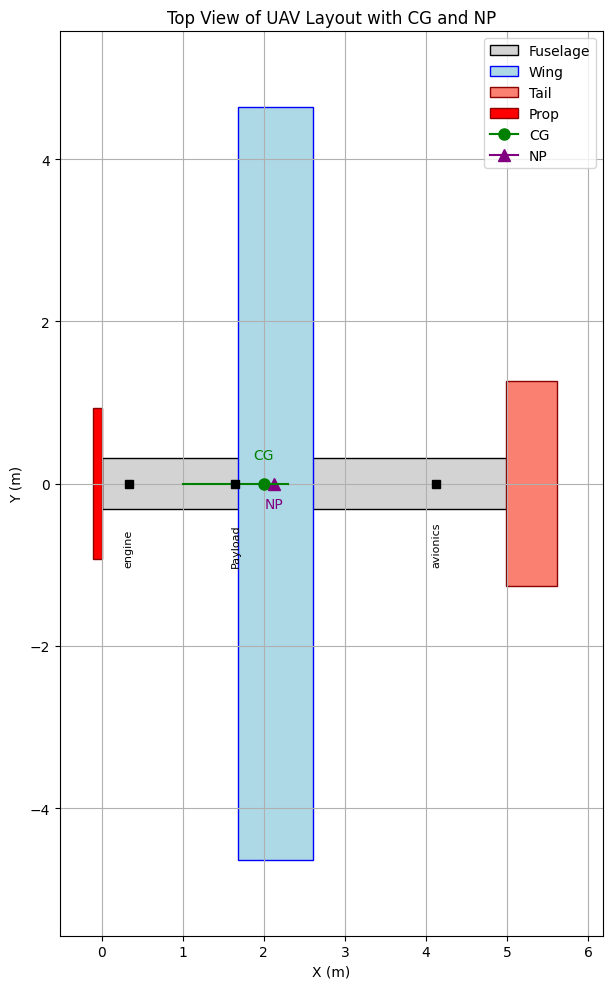

In [16]:


components, components_z = estimate_component_positions(predrop, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

components = {"engine":components["engine"], "Payload":components["internal_payload"], "avionics":components["avionics"]}#, "wing_payload": components["wing_payload"]}

# components = {}

# h_tail_le_position = predrop["cruiseout_cg_from_nose_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
# h_tail_le_position = predrop["x_ht_le_m"]
# h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]

plot_uav_top_view(
    fuselage_length=predrop["fuselage_body_length_m"],
    fuselage_width=predrop["fuselage_body_width_m"],
    wing_span=predrop["wing_span_m"],
    wing_chord=predrop["chord_m"],
    wing_le_position=predrop["wing_le_position_m"],
    tail_span=predrop["h_tail_span_m"],
    tail_chord=predrop["h_tail_chord_m"],
    tail_le_position=h_tail_le_position,
    components=components,
    cg_position=predrop["cruiseout_cg_from_nose_m"],
    np_position=predrop["neutral_point_m"],
)



In [12]:
def solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel,
                     lam_update=0.25, newton_tol=1e-5, newton_itmax=30, newton_damper=0.5):
    """
    Solve trim for one phase ('cruiseout'|'loiter'|'cruiseback') and write results into `cur`.
    No external dependencies beyond your existing helpers: kmh_to_ms, get_air_density, calc_cd_total.
    """

    # --- helpers (local, no external calls except your known helpers) ---
    import numpy as np

    def _interp_col_vs_alpha(df, a_deg, col):
        d = df.sort_values("alpha")
        return float(np.interp(a_deg, d["alpha"].values, d[col].values))

    def _CLw(a_deg):
        df0 = deflections_dict["cruise_0"]  # same polar family for cruise phases
        return _interp_col_vs_alpha(df0, a_deg, "CL")

    def _CMw(a_deg):
        df0 = deflections_dict["cruise_0"]
        return _interp_col_vs_alpha(df0, a_deg, "CM")

    def _CDw(a_deg):
        df0 = deflections_dict["cruise_0"]
        return _interp_col_vs_alpha(df0, a_deg, "CD")

    def _CLt_bilinear(alpha_t_deg, delta_e_deg):
        # blend between the two nearest elevator tables for this alpha_t
        keys = [k for k in deflections_dict.keys() if k.startswith("cruise_")]
        defs = sorted(int(k.split("_")[1]) for k in keys)
        j = np.searchsorted(defs, delta_e_deg)
        j0 = max(0, min(j-1, len(defs)-2))
        j1 = j0 + 1
        d0, d1 = defs[j0], defs[j1]
        w = 0.0 if d1 == d0 else (delta_e_deg - d0) / (d1 - d0)
        df0 = deflections_dict[f"cruise_{d0}"]
        df1 = deflections_dict[f"cruise_{d1}"]
        CL0 = _interp_col_vs_alpha(df0, alpha_t_deg, "CL")
        CL1 = _interp_col_vs_alpha(df1, alpha_t_deg, "CL")
        return (1.0 - w) * CL0 + w * CL1

    def _relax(old, new, lam):
        return (1.0 - lam) * old + lam * new if old is not None else new

    # --- environment & geometry frozen for inner solve ---
    V = kmh_to_ms(cur[f"{phase}_speed_kmh"])
    rho = get_air_density(hard_constraints["cruise_altitude_m"])
    q   = 0.5 * rho * V**2

    Sw   = cur["wing_area_m2"]
    Sh   = cur["horizontal_tail_area_m2"]
    cbar = cur["chord_m"]
    eta_h = calculate_eta_h(cur, phase=phase)

    # downwash gradient (∂ε/∂α), use your coeff or a sane default
    deda = float(assumed_and_set.get("ht_downwash_efficiency_coeff", 0.35))

    # incidences (deg)
    i_w = float(assumed_and_set["wing_incident_angle"])
    i_h = float(assumed_and_set["ht_incident_angle"])

    # aerodynamic centers (if missing, fall back to simple 0.25c and tail arm)
    # EXPECTED: you already compute these per phase; keep them frozen inside this solve
    xac_w = cur.get(f"{phase}_x_ac_w_m", cur["wing_le_position_m"] + 0.25*cur["chord_m"])
    xac_h = cur.get(f"{phase}_x_ht_ac_m", xac_w + cur["tail_arm_m"])

    # phase CG
    xcg = cur[f"{phase}_cg_from_nose_m"]

    # phase weight (N) — use your smoothed fuel split already in cur
    # cruiseback: payloads already zeroed elsewhere; we just sum what exists
    W_kg = (weights_dict_kg_no_fuel["fuselage"] +
            weights_dict_kg_no_fuel["wing"] +
            weights_dict_kg_no_fuel["tails"] +
            weights_dict_kg_no_fuel["engine"] +
            weights_dict_kg_no_fuel["propeller"] +
            weights_dict_kg_no_fuel["avionics"] +
            weights_dict_kg_no_fuel["landing_gear"] +
            weights_dict_kg_no_fuel["misc"] +
            cur.get("fuselage_fuel", 0.0) +
            cur.get("wing_fuel", 0.0) +
            (weights_dict_kg_no_fuel.get("internal_payload", 0.0) if phase != "cruiseback" else 0.0) +
            (weights_dict_kg_no_fuel.get("wing_payload", 0.0)     if phase != "cruiseback" else 0.0))
    W = W_kg * g

    # elevator bounds from available tables
    defs_all = sorted(int(k.split("_")[1]) for k in deflections_dict if k.startswith("cruise_"))
    de_min, de_max = float(defs_all[0]), float(defs_all[-1])

    # --- residuals (lift & pitch-moment about CG) ---
    def _res(alpha_w_deg, delta_e_deg):
        CLw = _CLw(alpha_w_deg)
        CMw = _CMw(alpha_w_deg)
        alpha_t_deg = alpha_w_deg * (1.0 - deda) + (i_h - i_w)
        CLt = _CLt_bilinear(alpha_t_deg, delta_e_deg)

        F1 = q*Sw*CLw + q*Sh*eta_h*CLt - W
        F2 = q*Sw*cbar*(CMw + CLw*((xac_w - xcg)/cbar)) + q*Sh*cbar*(eta_h*CLt*((xac_h - xcg)/cbar))
        return np.array([F1, F2], dtype=float), CLw, CLt, alpha_t_deg

    # --- damped Newton (finite-diff J) ---
    a0 = float(cur.get(f"{phase}_angle_of_attack_deg", 2.0))
    de0 = float(cur.get(f"{phase}_delta_elevator_deg", 0.0))
    x = np.array([a0, de0], dtype=float)
    ok = False
    for _ in range(newton_itmax):
        F, CLw, CLt, alpha_t = _res(x[0], x[1])
        if np.linalg.norm(F, ord=np.inf) < newton_tol:
            ok = True
            break
        J = np.zeros((2,2))
        h = np.array([1e-3, 1e-3])
        for j in range(2):
            xh = x.copy(); xh[j] += h[j]
            Fh, *_ = _res(xh[0], xh[1])
            J[:, j] = (Fh - F) / h[j]
        try:
            dx = np.linalg.solve(J, -F)
        except np.linalg.LinAlgError:
            dx = -0.1 * np.sign(F)  # gentle fallback
        x_new = x + newton_damper * dx
        x_new[1] = np.clip(x_new[1], de_min, de_max)  # actuator limits
        # tiny extra relaxation to kill any hidden 2-cycle
        x = 0.75*x + 0.25*x_new

    alpha_w_deg, delta_e_deg = float(x[0]), float(np.clip(x[1], de_min, de_max))
    # final eval
    _, CLw, CLt, alpha_t_deg = _res(alpha_w_deg, delta_e_deg)
    CDw = _CDw(alpha_w_deg)
    # simple tail CD (keep your existing induced/profile model here)
    CDt = calc_cd_total(_interp_col_vs_alpha(deflections_dict["cruise_0"], 0.0, "CD"),
                        CLt, assumed_and_set["AR_horizontal"])

    # drag & power
    D = q * (Sw*CDw + Sh*CDt)
    eta_p = propeller_specs["efficiency"]["cruise"]
    eta_g = engine_specs["gear_box_efficiency"]
    P_kw_new = D * V / (eta_p * eta_g) / 1000.0

    # --- write back to cur with light damping (sleek, non-invasive) ---
    cur[f"{phase}_angle_of_attack_deg"] = _relax(cur.get(f"{phase}_angle_of_attack_deg"), alpha_w_deg, lam_update)
    cur[f"{phase}_delta_elevator_deg"]  = _relax(cur.get(f"{phase}_delta_elevator_deg"),  delta_e_deg, lam_update)
    cur[f"{phase}_cl"]                  = _relax(cur.get(f"{phase}_cl"),                  CLw,        lam_update)
    cur[f"{phase}_cl_tail_required"]    = _relax(cur.get(f"{phase}_cl_tail_required"),    CLt,        lam_update)
    cur[f"{phase}_cd"]                  = _relax(cur.get(f"{phase}_cd"),                  CDw,        lam_update)
    cur[f"{phase}_cd_tail"]             = _relax(cur.get(f"{phase}_cd_tail"),             CDt,        lam_update)
    cur[f"{phase}_power_kw"]            = _relax(cur.get(f"{phase}_power_kw"),            P_kw_new,   lam_update)

    # (optionally stash tail AoA for debugging/plots)
    cur[f"{phase}_alpha_tail_deg"]      = _relax(cur.get(f"{phase}_alpha_tail_deg"),      alpha_t_deg, lam_update)

    # return a small status dict if you want to log/inspect
    return {"ok": ok, "alpha_w_deg": alpha_w_deg, "delta_e_deg": delta_e_deg,
            "CLw": CLw, "CLt": CLt, "CDw": CDw, "CDt": CDt, "P_kw": P_kw_new}


def evaluate_fuel_variant_with_to(cur, assumed_and_set, hard_constraints,
                                  weights_dict_kg_no_fuel, deflections_dict,
                                  *,
                                  add_fuel_kg=0.0,
                                  set_total_fuel_kg=None,
                                  payload_internal_kg=None,
                                  payload_wing_kg=None,
                                  cap_by_volume=True,
                                  wing_fuel_tank_volume_fn=None,   # e.g. lambda c: wing_fuel_tank_volume(..., c, 0.25, 0.65)
                                  steps_integral=24,
                                  use_sfc_map=False,
                                  engine_power_to_rpm=None,
                                  engine_sfc_to_rpm=None,
                                  # takeoff model knobs (sensible defaults)
                                  liftoff_vs_factor=1.15,
                                  CL_ground_factor=0.80,
                                  Oswald_e=0.80,
                                  prop_eta_takeoff=None,            # if None, falls back to propeller_specs["efficiency"].get("takeoff", 0.70)
                                  thrust_static_N=None,             # if you have a static thrust estimate; else None
                                  dv_mps=0.5):
    """
    Evaluate SAME design with altered fuel/payload. Adds takeoff speed/distance.
    - Wing-first fuel draw; geometry/aero frozen.
    - Fixed engine max power from engine_specs["max_power_kw"] (required <= available check).
    - Returns dict with per-phase trim/power/stability, TO metrics, max endurance/range.

    Dependencies expected in scope:
      g, kmh_to_ms, get_air_density, calculate_cg, estimate_component_positions,
      solve_phase_trim, stability_analysis, calc_cd_total,
      engine_specs (with 'max_power_kw' and 'gear_box_efficiency'),
      propeller_specs (with 'efficiency' dict).
    """
    import copy, math
    import numpy as np

    g_local = 9.81
    x  = copy.deepcopy(cur)
    w0 = copy.deepcopy(weights_dict_kg_no_fuel)

    # ----------------- Payload overrides (no redesign) -----------------
    if payload_internal_kg is not None: w0["internal_payload"] = float(payload_internal_kg)
    if payload_wing_kg     is not None: w0["wing_payload"]     = float(payload_wing_kg)

    # ----------------- Fuel capacities (volume caps) -------------------
    fuel_rho = float(assumed_and_set["fuel_density_kgL"]) * 1000.0
    fus_t = sandwich_specs["fuselage"]["total_thickness_m"]
    w_in  = x["fuselage_body_width_m"]  - 2*fus_t - 0.02
    h_in  = x["fuselage_body_height_m"] - 2*fus_t - 0.02
    w_in  = max(0.0, w_in); h_in = max(0.0, h_in)
    V_fuse_m3 = max(0.0, assumed_and_set["fuselage_fuel_tank_length"] * (w_in * h_in))

    if callable(wing_fuel_tank_volume_fn):
        V_wing_m3 = max(0.0, float(wing_fuel_tank_volume_fn(x)))
    else:
        V_total_prev = float(x.get("space_available_for_fuel_m3", 0.0))
        V_wing_m3 = max(0.0, V_total_prev - V_fuse_m3)

    cap_fuse_kg  = V_fuse_m3 * fuel_rho
    cap_wing_kg  = V_wing_m3 * fuel_rho
    cap_total_kg = cap_fuse_kg + cap_wing_kg

    fus_fuel = float(x.get("fuselage_fuel", 0.0))
    wing_fuel= float(x.get("wing_fuel",     0.0))
    base_total = fus_fuel + wing_fuel

    if set_total_fuel_kg is not None:
        fuel_total_target = max(0.0, float(set_total_fuel_kg))
    else:
        fuel_total_target = max(0.0, base_total + float(add_fuel_kg))
    if cap_by_volume:
        fuel_total_target = min(fuel_total_target, cap_total_kg)

    # Fill policy: fuselage first, remainder to wing (your original convention)
    delta = fuel_total_target - base_total
    if delta >= 0.0:
        add_to_fus = min(delta, max(0.0, cap_fuse_kg - fus_fuel))
        fus_fuel += add_to_fus
        rem = delta - add_to_fus
        wing_fuel += min(rem, max(0.0, cap_wing_kg - wing_fuel))
    else:
        take = -delta
        take_w = min(take, wing_fuel)
        wing_fuel -= take_w
        take -= take_w
        fus_fuel -= min(take, fus_fuel)

    # ------------- Helpers: weights/CG, fuel draw, SFC, power caps -------------
    def phase_weight_and_cg(phase, fus_fuel_kg, wing_fuel_kg):
        w_phase = copy.deepcopy(w0)
        if phase == "cruiseback":
            w_phase["internal_payload"] = 0.0
            w_phase["wing_payload"]     = 0.0
        w_phase["fuselage_fuel"] = max(0.0, fus_fuel_kg)
        w_phase["wing_fuel"]     = max(0.0, wing_fuel_kg)
        comp_x, comp_z = estimate_component_positions(x, hard_constraints, assumed_and_set, w_phase)
        Wkg = sum(w_phase.values())
        xcg = calculate_cg(w_phase, comp_x)
        zcg = calculate_cg(w_phase, comp_z)
        return Wkg, xcg, zcg

    def draw_burn(wing_kg, fus_kg, burn_kg):
        b = max(0.0, burn_kg)
        d_w = min(b, wing_kg)
        wing_kg -= d_w
        b -= d_w
        d_f = min(b, fus_kg)
        fus_kg -= d_f
        b -= d_f
        return wing_kg, fus_kg, (d_w + d_f), b

    def sfc_for_power_kw(phase, P_kw):
        if use_sfc_map and (engine_power_to_rpm is not None) and (engine_sfc_to_rpm is not None):
            data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_kw)
            return float(data["sfc_cruise"])
        key = f"{phase}_sfc"
        if key in x and x[key] is not None:
            return float(x[key])
        return 0.60  # kg/kWh fallback

    # maximum available shaft power (fixed engine)
    Pmax_kw = float(engine_specs.get("max_power_kw", engine_specs.get("max_cruise_power_kw", 999.0)))
    eta_gbx = float(engine_specs["gear_box_efficiency"])
    eta_prop_takeoff = (prop_eta_takeoff if prop_eta_takeoff is not None
                        else float(propeller_specs["efficiency"].get("takeoff", 0.70)))
    eta_prop_cruise  = float(propeller_specs["efficiency"].get("cruise", 0.75))

    def solve_phase(phase, fus_fuel_kg, wing_fuel_kg):
        # weight/CG
        Wkg, xcg, zcg = phase_weight_and_cg(phase, fus_fuel_kg, wing_fuel_kg)
        x[f"{phase}_cg_from_nose_m"]  = xcg
        x[f"{phase}_cg_from_floor_m"] = zcg
        # trim + power required
        solve_phase_trim(x, assumed_and_set, hard_constraints, deflections_dict, phase, w0)
        # stability
        stab = stability_analysis(x, assumed_and_set, deflections_dict, phase)
        x[f"{phase}_static_margin"] = stab["static_margin"]
        # enforce power cap check (we don't rescale speed here; we flag infeasible)
        P_req = float(x[f"{phase}_power_kw"])
        over = P_req > Pmax_kw + 1e-9
        return {
            "Wkg": Wkg,
            "xcg": xcg,
            "zcg": zcg,
            "CLw": x[f"{phase}_cl"],
            "CLt": x.get(f"{phase}_cl_tail_required", 0.0),
            "CDw": x[f"{phase}_cd"],
            "CDt": x.get(f"{phase}_cd_tail", 0.0),
            "P_req_kw": P_req,
            "P_max_kw": Pmax_kw,
            "power_ok": (not over),
            "AoA_deg": x[f"{phase}_angle_of_attack_deg"],
            "de_deg":  x[f"{phase}_delta_elevator_deg"],
            "SM":      x[f"{phase}_static_margin"],
        }

    # ---------------------- Mission sequence (wing-first burn) ----------------------
    # 1) Cruise-out
    out = solve_phase("cruiseout", fus_fuel, wing_fuel)
    t_out_hr = hard_constraints["target_station_distance_km"] / max(1e-9, x["cruiseout_speed_kmh"])
    sfc_out  = sfc_for_power_kw("cruiseout", out["P_req_kw"])
    burn_out = out["P_req_kw"] * t_out_hr * sfc_out
    wing_fuel, fus_fuel, burned, unmet = draw_burn(wing_fuel, fus_fuel, burn_out)
    if unmet > 1e-9:
        frac = burned / max(1e-9, burn_out)
        t_out_hr *= frac  # couldn’t complete leg

    # 2) Loiter
    lo = solve_phase("loiter", fus_fuel, wing_fuel)
    t_lo_hr = float(hard_constraints["loiter_time"])
    sfc_lo  = sfc_for_power_kw("loiter", lo["P_req_kw"])
    burn_lo = lo["P_req_kw"] * t_lo_hr * sfc_lo
    wing_fuel, fus_fuel, burned, unmet = draw_burn(wing_fuel, fus_fuel, burn_lo)
    if unmet > 1e-9:
        frac = burned / max(1e-9, burn_lo)
        t_lo_hr *= frac

    # 3) Cruise-back (no payloads)
    cb = solve_phase("cruiseback", fus_fuel, wing_fuel)
    t_cb_hr = hard_constraints["target_station_distance_km"] / max(1e-9, x["cruiseback_speed_kmh"])
    sfc_cb  = sfc_for_power_kw("cruiseback", cb["P_req_kw"])
    burn_cb = cb["P_req_kw"] * t_cb_hr * sfc_cb
    wing_fuel, fus_fuel, burned, unmet = draw_burn(wing_fuel, fus_fuel, burn_cb)
    if unmet > 1e-9:
        frac = burned / max(1e-9, burn_cb)
        t_cb_hr *= frac

    # store final remaining fuel
    x["fuselage_fuel"] = fus_fuel; x["wing_fuel"] = wing_fuel
    x["fuel_kg"] = fus_fuel + wing_fuel

    # ---------------------- Takeoff performance (ground run) -----------------------
    # Assumptions: sea level; liftoff at V_LOF = liftoff_vs_factor * Vs (wing CLmax).
    rho0   = get_air_density(0.0)
    Sw     = x["wing_area_m2"]
    AR     = assumed_and_set["aspect_ratio"]
    e      = Oswald_e
    CD0    = float(get_row_for_cl(deflections_dict["cruise_0"], 0)["CD"])  # zero-lift CD from your polar
    k_ind  = 1.0 / (math.pi * e * AR)

    # takeoff weight = pre-mission weight (with payloads present)
    Wkg_to = (w0["fuselage"] + w0["wing"] + w0["tails"] + w0["engine"] + w0["propeller"] +
              w0["avionics"] + w0["landing_gear"] + w0["misc"] +
              w0.get("internal_payload", 0.0) + w0.get("wing_payload", 0.0) +
              fus_fuel + wing_fuel)  # using current loaded fuel
    WN_to  = Wkg_to * g_local

    CLmax  = hard_constraints["CL_max"]
    Vs_mps = math.sqrt( (2.0 * WN_to) / (rho0 * Sw * max(CLmax,1e-6)) )
    Vlof   = liftoff_vs_factor * Vs_mps

    # simple speed-dependent thrust model: T = min(T_static, η Pmax / V)
    if thrust_static_N is None:
        # crude cap: bound thrust at low speed using value at ~0.8*Vlof
        T_cap = (eta_prop_takeoff * Pmax_kw*1000.0 * eta_gbx) / max(0.8*Vlof, 1.0)
    else:
        T_cap = float(thrust_static_N)
    eta_TO = eta_prop_takeoff
    def thrust_at(V):
        # shaft power limited; gearbox included
        T_power = (eta_TO * (Pmax_kw*1000.0) * eta_gbx) / max(V, 1.0)  # N
        return min(T_cap, T_power)

    mu_roll = float(assumed_and_set["rolling_resistance_coefficient"])
    CL_gr   = CL_ground_factor * CLmax

    # integrate s = ∫ V/a dV from 0→Vlof (discretized with ΔV)
    s_run = 0.0
    V = 0.5  # start small to avoid divide by zero
    while V < Vlof:
        q = 0.5 * rho0 * V*V
        L = q * Sw * CL_gr
        D = q * Sw * (CD0 + k_ind * (CL_gr**2))
        T = thrust_at(V)
        N = max(0.0, WN_to - L)
        F_net = T - D - mu_roll * N
        a = max(0.1, F_net / Wkg_to)  # m/s^2; floor to avoid stall in integration
        # ds ≈ V * dV / a
        s_run += V * dv_mps / a
        V += dv_mps

    takeoff_results = {
        "Vs_kmh": Vs_mps * 3.6,
        "V_liftoff_kmh": Vlof * 3.6,
        "ground_run_m": s_run,
        "assumptions": {
            "liftoff_vs_factor": liftoff_vs_factor,
            "CL_ground_factor": CL_ground_factor,
            "CD0": CD0,
            "Oswald_e": e,
            "mu_roll": mu_roll,
            "prop_eta_takeoff": eta_TO,
            "thrust_static_N": (None if thrust_static_N is None else float(thrust_static_N)),
        }
    }

    # ---------------- Max endurance (loiter) & max range (cruise) ------------------
    # Start from the *loaded* (post-fill) tanks:
    fus_init, wing_init = fus_fuel + burn_cb + burn_lo + burn_out, wing_fuel + burn_cb + burn_lo + burn_out
    # But above reconstruction is messy; rebuild directly from target load and fill policy:
    def initial_split(total_kg):
        f_fus = min(total_kg, cap_fuse_kg)
        f_wng = min(max(0.0, total_kg - f_fus), cap_wing_kg)
        return f_fus, f_wng
    fus_init, wing_init = initial_split(fuel_total_target)

    def integrate_fuel_use(mode_phase, wing_kg_start, fus_kg_start, steps):
        total_t_hr = 0.0
        total_R_km = 0.0
        wing_k = wing_kg_start; fus_k = fus_kg_start
        fuel_avail = wing_k + fus_k
        if fuel_avail <= 1e-9: return 0.0, 0.0, 0.0
        for _ in range(steps):
            fuel_left = wing_k + fus_k
            if fuel_left <= 1e-9: break
            take = fuel_avail / steps
            if take > fuel_left: take = fuel_left
            ph = solve_phase(mode_phase, fus_k, wing_k)
            # if required power exceeds max, we cannot sustain this mode at current speed
            if ph["P_req_kw"] > Pmax_kw + 1e-9:
                # treat as infeasible: stop integration for this mode
                break
            sfc = sfc_for_power_kw(mode_phase, ph["P_req_kw"])
            dt_hr = take / max(1e-9, (ph["P_req_kw"] * sfc))
            V_kmh = x[f"{mode_phase}_speed_kmh"]
            total_t_hr += dt_hr
            total_R_km += V_kmh * dt_hr
            wing_k, fus_k, _, _ = draw_burn(wing_k, fus_k, take)
        used = (wing_kg_start + fus_kg_start) - (wing_k + fus_k)
        return total_t_hr, total_R_km, used

    E_hr, _, _ = integrate_fuel_use("loiter", wing_init, fus_init, steps_integral)
    _,  R_km, _ = integrate_fuel_use("cruiseout", wing_init, fus_init, steps_integral)

    # ---------------- Package & return --------------------------------------------
    results = {
        "fuel_capacity_kg":      cap_total_kg,
        "fuel_loaded_kg":        fuel_total_target,
        "fuel_capped":           (fuel_total_target >= cap_total_kg - 1e-6) if cap_by_volume else False,
        "tank_capacity": {
            "fuselage_max_kg": cap_fuse_kg,
            "wing_max_kg":     cap_wing_kg,
        },
        "takeoff": takeoff_results,
        "phase": {
            "cruiseout": out,
            "loiter":    lo,
            "cruiseback":cb,
        },
        "mission_times_hr": {
            "cruiseout": t_out_hr,
            "loiter":    t_lo_hr,
            "cruiseback":t_cb_hr,
        },
        "post_mission_fuel_kg": {
            "fuselage": fus_fuel,
            "wing":     wing_fuel,
            "total":    fus_fuel + wing_fuel,
        },
        "max_endurance_loiter_hr": E_hr,
        "max_range_cruise_km":     R_km,
        "power_caps": {
            "engine_max_power_kw": Pmax_kw,
            "gearbox_efficiency":  eta_gbx,
            "prop_eta_cruise":     eta_prop_cruise,
            "prop_eta_takeoff":    eta_TO,
            "phase_power_ok": {
                "cruiseout": out["power_ok"],
                "loiter":    lo["power_ok"],
                "cruiseback":cb["power_ok"],
            }
        }
    }
    return results


In [13]:
baseline_eval = evaluate_fuel_variant_with_to(
    predrop,             # current_values dictionary (cur)
    assumed_and_set,
    hard_constraints,
    weights_dict_kg_no_fuel,
    deflections_dict,
)

In [22]:
baseline_eval.keys()

dict_keys(['fuel_capacity_kg', 'fuel_loaded_kg', 'fuel_capped', 'tank_capacity', 'takeoff', 'phase', 'mission_times_hr', 'post_mission_fuel_kg', 'max_endurance_loiter_hr', 'max_range_cruise_km', 'power_caps'])